In [1]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

Get Technical Features

In [2]:
sp1500 = pd.read_excel("../data/SPR as of Feb 12 20251.xlsx")
tickers = sp1500['Ticker'].str.split(" ").str[0]

In [3]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Get the parent directory of the current working directory

# Construct the path to the `src` directory
src_path = os.path.join(project_root, "src")

# Add the `src` directory to the Python module search path
sys.path.append(src_path)


In [4]:
import importlib
from Features import technical_features_new

importlib.reload(technical_features_new)
from Features.technical_features_new import BuildFeatures

In [5]:
# Generate all NYSE trading days from 1980 to 2025
all_dates = pd.bdate_range(start="1980-01-01", end="2025-02-24", freq="B") 
date_to_qid = {date: qid for qid, date in enumerate(all_dates)}

In [53]:
import pickle as pkl
import gzip
from tqdm import tqdm

# Define storage path
cache_path = "../data/technical_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

# Process stock data
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    try:
        obj = BuildFeatures(tick)
    except:
        continue
    
    obj.build_technical_features()  # Compute technical indicators
    data = obj.technical_features.copy()
        
    if data.empty:
        continue
    
    data["Close"] = obj.stock["Close"]
    data = data.resample('BM').last()
    data["Return"] = data["Close"].pct_change().shift(-1).astype(np.float32)

    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")


Processing Tickers: 100%|██████████| 1506/1506 [22:14<00:00,  1.13ticker/s] 

✅ All data has been successfully stored and optimized with compression!


In [6]:
import importlib
from Features import fundamental_features_new

importlib.reload(fundamental_features_new)
from Features.fundamental_features_new import BuildFeatures as BuildFundamentalFeatures

In [7]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

zack_data = {}
zack_data["zacks_fc"] = zacks_fc
zack_data["zacks_fr"] = zacks_fr


In [8]:
from tqdm import tqdm
import pickle as pkl
import gzip

# Define storage path
cache_path = "../data/fundamental_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):

    try:
        obj = BuildFundamentalFeatures(zack_data, tick)
    except:
        continue

    obj.process_financial_statements()  # Generate technical features for the ticker
    
    # Merge technical features with the calculated returns
    data = obj.fundamental_features.copy()
    
    if data.empty:
        continue

    data = data[data['per_type'] == 'Q']
    data['filing_date'] = pd.to_datetime(data['filing_date'])
    data.index.name = 'report_date'
    data = data.reset_index()
    
    data = data.set_index('filing_date')
    data['filing_date'] = data.index
    try:
        full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="D")
    except:
        continue
    
    data = data.drop_duplicates(subset="filing_date", keep="last")
    data = data.reindex(full_date_range)
    data = data.ffill().resample('BM').last()
    
    data["Close"] = obj.stock['Close']
    
    data["Return"] = data["Close"].pct_change().shift(-1)
    
    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")

Processing Tickers:  10%|█         | 151/1506 [01:48<21:54,  1.03ticker/s]

In [20]:
from tqdm import tqdm
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
import os

# Set cutoff dates for training, validation, and test sets
train_cutoff = "2014-01-01"
valid_cutoff = "2018-01-01"

# Paths
data_path_tech = "../data/technical_features"
data_path_fin = "../data/fundamental_features"

# List to store all data
all_data = []

# Process all tickers
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    file_path_tech = os.path.join(data_path_tech, f"{tick}.pkl.gz")
    file_path_fin = os.path.join(data_path_fin, f"{tick}.pkl.gz")
    try:
        # Load technical data
        with gzip.open(file_path_tech, "rb") as f:
            tech_data = pkl.load(f)
            tech_data["Ticker"] = tick

        # Load fundamental data
        with gzip.open(file_path_fin, "rb") as f:
            fin_data = pkl.load(f)
            fin_data = fin_data.dropna(axis=1, how="all")
            fin_data = fin_data.select_dtypes(include=[float, int])  # Keep only numeric columns

        combined_data = tech_data.merge(fin_data, how="outer", left_index=True, right_index=True)
        combined_data['Return'] = combined_data['Return_x'].fillna(combined_data['Return_y'])
        combined_data = combined_data.drop(columns=['Return_x', 'Return_y'])
        combined_data = combined_data.dropna(subset=['Return'])
        combined_data = combined_data.ffill()
        combined_data.index.name = 'date'
    except:
        continue

    all_data.append(combined_data)

# Merge all data and sort by date
all_data_df = pd.concat(all_data).sort_index()
all_data_df = all_data_df.dropna(subset=["Return"])

# Define threshold for missing values
threshold = len(all_data_df) * 0.3
all_data_df = all_data_df.dropna(axis=1, thresh=threshold)
all_data_df = all_data_df.dropna()

# Assign qid values based on unique dates
unique_dates = all_data_df.index.unique()
date_to_qid = {date: i for i, date in enumerate(unique_dates)}
all_data_df["qid"] = all_data_df.index.map(date_to_qid).astype(np.int32)

# Compute quintile ranking for stock returns
def compute_ranked_labels(df):
    df["Ranked_Return"] = df.groupby("qid")["Return"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop")  # 0-4 ranking
    ).astype(np.int32)
    return df

all_data_df = compute_ranked_labels(all_data_df)

# Split dataset
train_data = all_data_df[all_data_df.index < train_cutoff]
valid_data = all_data_df[(all_data_df.index >= train_cutoff) & (all_data_df.index < valid_cutoff)]
test_data = all_data_df[all_data_df.index >= valid_cutoff]

# Extract features and labels
def extract_features_labels(df):
    X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
    y = df["Ranked_Return"].values
    qid = df["qid"].values
    return X, y, qid

X_train, y_train, qid_train = extract_features_labels(train_data)
X_valid, y_valid, qid_valid = extract_features_labels(valid_data)
X_test, y_test, qid_test = extract_features_labels(test_data)

# Bootstrap sampling function
def bootstrap_sampling(X, y, qid, num_samples=10):
    N = X.shape[0]
    bootstrap_datasets = []
    for _ in range(num_samples):
        indices = np.random.choice(N, N, replace=True)  # Bootstrap sampling
        X_sample, y_sample, qid_sample = X[indices], y[indices], qid[indices]
        bootstrap_datasets.append((X_sample, y_sample, qid_sample))
    return bootstrap_datasets

# Generate bootstrap train sets
bootstrap_train_datasets = bootstrap_sampling(X_train, y_train, qid_train, num_samples=10)

# Save dataset
dataset = {
    "train": (X_train, y_train, qid_train),
    "bootstrap_train": bootstrap_train_datasets,
    "valid": (X_valid, y_valid, qid_valid),
    "test": (X_test, y_test, qid_test),
}


Processing Tickers: 100%|██████████| 1506/1506 [00:06<00:00, 219.37ticker/s]


In [31]:
import xgboost as xgb
import numpy as np

models = []  # Store all trained XGBRanker models
valid_scores = []  # Store the best NDCG scores on the validation set

X_valid, y_valid, qid_valid = dataset["valid"]  # Extract validation dataset

# Iterate over bootstrap-sampled training datasets
for i, (X_sample, y_sample, qid_sample) in enumerate(dataset["bootstrap_train"]):
    print(f"Training model {i+1} ...")

    # Initialize XGBRanker
    model = xgb.XGBRanker(
        objective="rank:pairwise",
        n_estimators=500,  # Set a sufficiently large number of estimators, allowing early stopping to determine the best iteration
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        eval_metric="ndcg",  
        colsample_bytree=0.8,
        early_stopping_rounds=20
    )
    
    # Train the model with early stopping on the validation set
    model.fit(
        X_sample, y_sample, 
        group=np.bincount(qid_sample),  # Training group information
        eval_set=[(X_valid, y_valid)],  # Pass validation dataset
        eval_group=[np.bincount(qid_valid)],  # Validation dataset group information
        verbose=True
    )

    # Store trained model and best validation score
    models.append(model)
    valid_scores.append(model.best_score)  # best_score: XGBoost automatically records the best NDCG score


训练模型 1 ...
[0]	validation_0-ndcg:0.79965
[1]	validation_0-ndcg:0.80083
[2]	validation_0-ndcg:0.79979
[3]	validation_0-ndcg:0.80430
[4]	validation_0-ndcg:0.79970
[5]	validation_0-ndcg:0.80064
[6]	validation_0-ndcg:0.80137
[7]	validation_0-ndcg:0.80168
[8]	validation_0-ndcg:0.80369
[9]	validation_0-ndcg:0.80319
[10]	validation_0-ndcg:0.80374
[11]	validation_0-ndcg:0.80168
[12]	validation_0-ndcg:0.80302
[13]	validation_0-ndcg:0.80062
[14]	validation_0-ndcg:0.80174
[15]	validation_0-ndcg:0.80159
[16]	validation_0-ndcg:0.80216
[17]	validation_0-ndcg:0.80242
[18]	validation_0-ndcg:0.80132
[19]	validation_0-ndcg:0.80229
[20]	validation_0-ndcg:0.80309
[21]	validation_0-ndcg:0.80262
[22]	validation_0-ndcg:0.80213
[23]	validation_0-ndcg:0.80070
训练模型 2 ...
[0]	validation_0-ndcg:0.79609
[1]	validation_0-ndcg:0.79664
[2]	validation_0-ndcg:0.79892
[3]	validation_0-ndcg:0.80021
[4]	validation_0-ndcg:0.80060
[5]	validation_0-ndcg:0.80325
[6]	validation_0-ndcg:0.80307
[7]	validation_0-ndcg:0.80115
[8]	

In [33]:
X_test

array([[ 2.71740000e+01,  2.49244000e+01,  1.63161779e+09, ...,
         7.04990000e+00,  3.41990000e+00,  3.11290000e+00],
       [ 7.96682000e+01,  7.72938500e+01,  5.88441606e+08, ...,
         3.50585000e+01,  2.31160000e+00,  1.44090000e+00],
       [ 3.07229520e+01,  2.67559475e+01,  8.17630854e+04, ...,
         3.88709000e+01,  3.20930000e+00,  1.87730000e+00],
       ...,
       [ 1.01502000e+01,  1.38407500e+01, -2.55976014e+08, ...,
         2.85629000e+01, -2.27000000e+00,  1.26680000e+00],
       [ 1.38136000e+01,  1.33052500e+01,  4.20160689e+08, ...,
         6.94850000e+00,  2.61300000e-01,  2.62020000e+00],
       [ 2.90638000e+02,  2.86053250e+02,  1.63061977e+07, ...,
         8.78971000e+01,  1.77354000e+01,  2.02860000e+00]])

In [37]:
import numpy as np
from sklearn.metrics import ndcg_score

# Retrieve test dataset
X_test, y_test, qid_test = dataset["test"]

test_preds = np.zeros((len(models), len(X_test)))  # Store predictions from all models

# Iterate over all bootstrap-trained models
for i, model in enumerate(models):
    test_preds[i, :] = model.predict(X_test)  # Get predictions from each model

# Compute the final ensemble prediction (mean of all model predictions)
final_test_preds = np.mean(test_preds, axis=0)

# Create a DataFrame to store predictions
predictions = pd.DataFrame({
    "qid": qid_test,  # Query ID (date)
    "y_true": y_test,  # Ground truth labels
    "y_pred": final_test_preds  # Ensemble model predictions
}).sort_values(by="qid")  # Sort by query ID for consistency


In [39]:
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions['return_true'] = test_data_selected['Return']
predictions["date"] = test_data_selected['date']

In [40]:
predictions

,qid,y_true,y_pred,return_true,date
0,143,0,-0.23291592,-0.10671937,2018-01-31
541,143,0,-0.24659072,-0.20564340,2018-01-31
542,143,1,-0.09342641,-0.09692521,2018-01-31
543,143,1,-0.14712018,-0.08282828,2018-01-31
544,143,4,-0.26521913,0.14625071,2018-01-31
...,...,...,...,...,...
73200,227,2,-0.25510703,-0.03538066,2025-01-31
73201,227,4,-0.27711956,0.05698339,2025-01-31
73202,227,1,-0.22702543,-0.06476042,2025-01-31
73176,227,0,-0.20583616,-0.20742595,2025-01-31


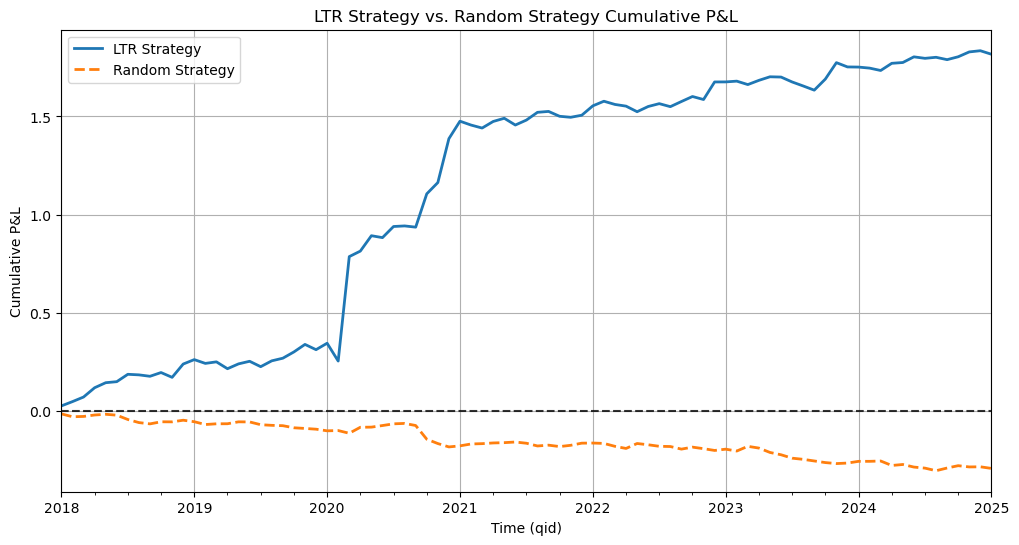

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 50
position_size = 1/(top_k*2)
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Sort stocks by predicted return `y_pred` within each `qid`
df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Step 2: Select long and short positions
df["long"] = (df["rank"] <= top_k).astype(int)
df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)

# Step 3: Compute returns
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions are negative

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()

In [42]:
performance_df

,Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio
0,LTR Strategy,0.25655638,0.24264292,1.05734129
1,Random Strategy,-0.04161098,0.04450038,-0.93507039
